Exercise 1: Train a classifier to predict the output labels of the given images. The training and validation images with their labels are given as numpy arrays (one row per image) in 5 chunks (see below). The test images (no labels) are given in a test.csv file (also with one row per image). The images are of size (32,32,3). 

- Write a Dataset class and use it for the dataloaders
- Build and train an appropriate NN
- Plot loss values during training and compute model accuracy

## Data uploading

In [ ]:
!wget -O data.zip https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
!unzip data.zip

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_

# data is given in 5 chunks, read into numpy arrays
dict1=unpickle("/content/cifar-10-batches-py/data_batch_1")
dict2=unpickle("/content/cifar-10-batches-py/data_batch_2")
dict3=unpickle("/content/cifar-10-batches-py/data_batch_3")
dict4=unpickle("/content/cifar-10-batches-py/data_batch_4")
dict5=unpickle("/content/cifar-10-batches-py/data_batch_5")

images1, labels1 = dict1[b"data"] , dict1[b"labels"]
images2, labels2 = dict2[b"data"] , dict2[b"labels"]
images3, labels3 = dict3[b"data"] , dict3[b"labels"]
images4, labels4 = dict4[b"data"] , dict4[b"labels"]
images5, labels5 = dict5[b"data"] , dict5[b"labels"]



--2023-01-16 10:15:23--  https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip [following]
--2023-01-16 10:15:24--  https://www.dropbox.com/s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb574f68b3f371c30a33b6ca618.dl-eu.dropboxusercontent.com/cd/0/inline/B0ohb-Jd_vG_aa56Re3IG0-teVfvMFoFYxBEBB7_GKPyigcDh-lVMjtqLUTVaXgDmngdTTtwWpp-uw0dRJQRHuRLUTOIgJ77SifshlG7SVBxr3xJsVqa-bamiGOP88pQzNUpCWGlob-qY1U4bC5toTEwhydGy2XE1NM5yIBWfRBPQg/file# [following]
--2023-01-16 10:15:24--  https://ucb574f68b3f371c30a33b6ca618.dl-eu.dropboxusercontent.com/cd/0/inline/B0ohb-Jd_vG_aa56Re3IG0-teVfvMFoFYxBE

## Dataset class and dataloaders
##### - Create a dataset class and use it to construct dataloaders for training and validation.
##### - Use one chunck of the data for validation and the rest for training. 
##### - Note: Concatenating numpy arrays can be done via np.concatenate()


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset





class MyData(Dataset):
  def __init__(self,imagesfile, labelsfile, transform=None):
    super().__init__()
    df_x = imagesfile
    df_y = labelsfile
    self.X = df_x.astype(np.float32).reshape(-1,3, 32,32)/255.0
    self.Y = df_y
    self.transform = transform

  def __len__(self):
    return len(self.Y)

  def __getitem__(self, idx):
    image = self.X[idx]
    image = torch.tensor(image) 
    
    if self.transform:
      image = self.transform(image)
    label = torch.tensor(self.Y[idx])
    return image, label

In [ ]:
imagesfile= np.concatenate((images1,images2,images3,images4), axis=0)
labelsfile= np.concatenate((labels1,labels2,labels3,labels4) , axis=0)
trainset = MyData(imagesfile,labelsfile)
imagesfile= images5
labelsfile= labels5
testset = MyData(imagesfile,labelsfile)


In [ ]:
len(trainset)

40000

In [ ]:
import matplotlib.pyplot as plt
import torch

import torchvision
batch_size = 16
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                         batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False)
# dataiter = iter(trainloader)
# images, labels = next(dataiter)



## Visualize the data
##### Show a few samples of the training dataset


In [ ]:
import matplotlib.pyplot as plt
import torch

import torchvision





# functions to show an image
def imshow(img):
    print(images.shape)
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Network definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1= nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2= nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
net = Net().to(device)
# net.to(device)
summary(net, (3, 32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,050
Trainable params: 62,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Total Size (MB): 0.36
---------------------------------------------

## Training
##### Plot loss values during training

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
ls = []
for epoch in range(30):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        device = "cuda" if torch.cuda.is_available() else "cpu"
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        ls.append(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
#the plot 


[1,  2000] loss: 0.400
[2,  2000] loss: 0.390
[3,  2000] loss: 0.380
[4,  2000] loss: 0.369
[5,  2000] loss: 0.358
[6,  2000] loss: 0.352
[7,  2000] loss: 0.341
[8,  2000] loss: 0.332
[9,  2000] loss: 0.319
[10,  2000] loss: 0.321
[11,  2000] loss: 0.305
[12,  2000] loss: 0.296
[13,  2000] loss: 0.288
[14,  2000] loss: 0.288
[15,  2000] loss: 0.278
[16,  2000] loss: 0.270
[17,  2000] loss: 0.268
[18,  2000] loss: 0.255
[19,  2000] loss: 0.262
[20,  2000] loss: 0.247
[21,  2000] loss: 0.249
[22,  2000] loss: 0.239
[23,  2000] loss: 0.232
[24,  2000] loss: 0.232
[25,  2000] loss: 0.221
[26,  2000] loss: 0.215
[27,  2000] loss: 0.208
[28,  2000] loss: 0.213
[29,  2000] loss: 0.208
[30,  2000] loss: 0.198
Finished Training


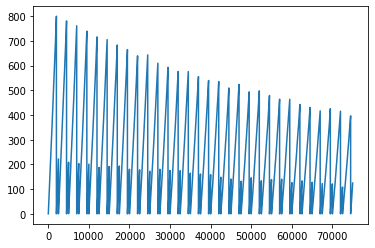

In [ ]:
from matplotlib.pylab import plt
plt.plot(ls, label='Training Loss')


## Validation
##### Compute model accuracy


In [ ]:
correct = 0
total = 0
# since we're not training, no need to calculate gradients
with torch.no_grad():
    for data in testloader:
        net.eval()
        images, labels = data
        # run images through the network
        outputs = net(images)
        # the class with highest val is the prediction
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 65 %


## Testing
##### Read the test.csv file into a numpy array, and then generate predictions
##### Save the predictions to a file that you will email with your code

In [ ]:
import pandas as pd

class MyTestData(Dataset):
  def __init__(self):
    super().__init__()
    df_x = pd.read_csv("/content/cifar-10-batches-py/test.csv" , header=None)
    
    self.X = df_x.to_numpy().astype(np.float32).reshape(-1,3, 32,32)/255.0
    

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    image = self.X[idx]
    image = torch.tensor(image) 
    
    # if self.transform:
    #   image = self.transform(image)
    # label = torch.tensor(self.Y[idx])
    return image




In [ ]:
X=MyTestData()
testloader = torch.utils.data.DataLoader(dataset=X, batch_size=batch_size,
                                         shuffle=False)

correct = 0
total = 0
prediction =[]
# since we're not training, no need to calculate gradients
with torch.no_grad():
    for data in testloader:
        images = data
        # run images through the network
        outputs = net(images)
        # the class with highest val is the prediction
        predicted = torch.argmax(outputs.data, 1)

        prediction.append(predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print(prediction) 
df = pd.DataFrame(prediction) #convert to a dataframe
df.to_csv("../content/sample_data/testfile.csv",index=False) #save to file

Accuracy of the network on the 10000 test images: 10 %
[array([3, 1, 2, 5, 5, 8, 1, 7, 0, 3, 0, 7, 6, 8, 6, 1]), array([0, 6, 9, 8, 0, 0, 8, 7, 1, 5, 7, 2, 9, 9, 1, 2]), array([9, 5, 2, 8, 7, 7, 8, 7, 2, 2, 0, 2, 4, 7, 6, 8]), array([2, 2, 5, 7, 8, 1, 4, 7, 5, 1, 5, 1, 4, 1, 4, 5]), array([5, 6, 3, 0, 4, 8, 6, 0, 6, 3, 3, 3, 5, 2, 1, 1]), array([6, 8, 1, 2, 9, 2, 7, 4, 0, 0, 6, 2, 9, 7, 3, 0]), array([3, 8, 6, 2, 8, 3, 3, 3, 8, 9, 2, 7, 4, 3, 1, 9]), array([3, 2, 5, 4, 8, 2, 8, 4, 1, 6, 7, 0, 3, 0, 5, 1]), array([4, 7, 3, 7, 2, 2, 6, 1, 8, 1, 5, 2, 8, 7, 9, 6]), array([9, 4, 9, 3, 0, 1, 3, 3, 4, 8, 4, 0, 7, 6, 2, 1]), array([4, 5, 0, 4, 5, 7, 1, 4, 4, 2, 3, 6, 2, 0, 5, 2]), array([1, 4, 7, 2, 8, 2, 0, 9, 0, 0, 9, 2, 0, 8, 9, 0]), array([3, 2, 2, 6, 5, 2, 7, 9, 1, 9, 6, 8, 2, 8, 3, 1]), array([3, 8, 1, 6, 7, 2, 8, 2, 8, 3, 8, 5, 8, 4, 4, 2]), array([3, 2, 6, 2, 4, 9, 3, 3, 8, 5, 8, 2, 1, 4, 5, 9]), array([1, 7, 6, 6, 6, 1, 6, 7, 3, 5, 2, 0, 6, 6, 8, 8]), array([3, 4, 9, 2, 5, 5, 3, 1, 3